# Installing Libraries

In [58]:
%pip install sklearn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: C:\Users\George Welson\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip


# Importing Libraries

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from copy import deepcopy as dc
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset,DataLoader

# Reading Clean Dataset

In [88]:
data = pd.read_csv("cleaned_dataset.csv")
data

,Date,Price
0,1988-08-01,0.8655
1,1988-08-02,0.8600
2,1988-08-03,0.8680
3,1988-08-04,0.8780
4,1988-08-05,0.8870
...,...,...
8883,2023-08-28,3.7920
8884,2023-08-29,3.8390
8885,2023-08-30,3.8440
8886,2023-08-31,3.8220


## Setting Date Column to Date Format

In [89]:
dates = pd.to_datetime(data["Date"])


# Setting Device to GPU

In [90]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

# Formatting for LSTM

In [91]:
dates = dates[7:]
dates


def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)
    df.set_index('Date', inplace=True)
    for i in range(1, n_steps+1):
        df[f'Price(t-{i})'] = df['Price'].shift(i)
    df.dropna(inplace=True)
    return df

lookback = 7
shifted_df = prepare_dataframe_for_lstm(data, lookback)
shifted_df

,Price,Price(t-1),Price(t-2),Price(t-3),Price(t-4),Price(t-5),Price(t-6),Price(t-7)
Date,,,,,,,,
1988-08-10,0.8875,0.8760,0.8710,0.8870,0.8780,0.8680,0.8600,0.8655
1988-08-11,0.9010,0.8875,0.8760,0.8710,0.8870,0.8780,0.8680,0.8600
1988-08-12,0.8835,0.9010,0.8875,0.8760,0.8710,0.8870,0.8780,0.8680
1988-08-15,0.8880,0.8835,0.9010,0.8875,0.8760,0.8710,0.8870,0.8780
1988-08-16,0.8880,0.8880,0.8835,0.9010,0.8875,0.8760,0.8710,0.8870
...,...,...,...,...,...,...,...,...
2023-08-28,3.7920,3.7790,3.7875,3.8305,3.7825,3.7465,3.7060,3.6915
2023-08-29,3.8390,3.7920,3.7790,3.7875,3.8305,3.7825,3.7465,3.7060
2023-08-30,3.8440,3.8390,3.7920,3.7790,3.7875,3.8305,3.7825,3.7465


In [92]:
shifted_df_before_scaling_as_np = shifted_df.to_numpy()

In [93]:
shifted_df_before_scaling_as_np

array([[0.8875, 0.876 , 0.871 , ..., 0.868 , 0.86  , 0.8655],
       [0.901 , 0.8875, 0.876 , ..., 0.878 , 0.868 , 0.86  ],
       [0.8835, 0.901 , 0.8875, ..., 0.887 , 0.878 , 0.868 ],
       ...,
       [3.844 , 3.839 , 3.792 , ..., 3.8305, 3.7825, 3.7465],
       [3.822 , 3.844 , 3.839 , ..., 3.7875, 3.8305, 3.7825],
       [3.8533, 3.822 , 3.844 , ..., 3.779 , 3.7875, 3.8305]])

# Scaling Data

In [94]:
scaler = MinMaxScaler(feature_range=(-1, 1))

shifted_df_after_scaling_as_np = scaler.fit_transform(shifted_df_before_scaling_as_np)

shifted_df_after_scaling_as_np

array([[-0.87110187, -0.87641488, -0.87872488, ..., -0.88011088,
        -0.88380688, -0.88126588],
       [-0.86486486, -0.87110187, -0.87641488, ..., -0.87549088,
        -0.88011088, -0.88380688],
       [-0.87294987, -0.86486486, -0.87110187, ..., -0.87133287,
        -0.87549088, -0.88011088],
       ...,
       [ 0.49480249,  0.49249249,  0.47077847, ...,  0.48856549,
         0.46638947,  0.44975745],
       [ 0.48463848,  0.49480249,  0.49249249, ...,  0.46869947,
         0.48856549,  0.46638947],
       [ 0.4990991 ,  0.48463848,  0.49480249, ...,  0.46477246,
         0.46869947,  0.48856549]])

In [95]:
X = shifted_df_after_scaling_as_np[:, 1:]
y = shifted_df_after_scaling_as_np[:, 0]

X.shape, y.shape

((8881, 7), (8881,))

In [96]:
X = dc(np.flip(X, axis=1))
X

array([[-0.88126588, -0.88380688, -0.88011088, ..., -0.87133287,
        -0.87872488, -0.87641488],
       [-0.88380688, -0.88011088, -0.87549088, ..., -0.87872488,
        -0.87641488, -0.87110187],
       [-0.88011088, -0.87549088, -0.87133287, ..., -0.87641488,
        -0.87110187, -0.86486486],
       ...,
       [ 0.44975745,  0.46638947,  0.48856549, ...,  0.46477246,
         0.47077847,  0.49249249],
       [ 0.46638947,  0.48856549,  0.46869947, ...,  0.47077847,
         0.49249249,  0.49480249],
       [ 0.48856549,  0.46869947,  0.46477246, ...,  0.49249249,
         0.49480249,  0.48463848]])

# Splitting to Traing Set and Testing Set 

In [97]:
split_index = int(len(X) * 0.80)
split_date = dates[split_index]

X_train = X[:split_index]
X_test = X[split_index:]
y_train = y[:split_index]
y_test = y[split_index:]
train_dates = dates[:split_index]
test_dates = dates[split_index:]

# Formatting as a TimeSeriesDataset

In [98]:
X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1)) 

In [99]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([7104, 7, 1]),
 torch.Size([1777, 7, 1]),
 torch.Size([7104, 1]),
 torch.Size([1777, 1]))

In [100]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

# Preparing DataLoader

In [101]:
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [102]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 7, 1]) torch.Size([16, 1])


In [103]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers,
                            batch_first=True)

        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(1, 4, 1)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

# Training and Optimising

In [104]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()

In [105]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)

    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [106]:
learning_rate = 0.001
num_epochs = 20
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#Adam does the gradient descent

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1
Batch 100, Loss: 0.503
Batch 200, Loss: 0.137
Batch 300, Loss: 0.018
Batch 400, Loss: 0.007

Val Loss: 0.026
***************************************************

Epoch: 2
Batch 100, Loss: 0.006
Batch 200, Loss: 0.005
Batch 300, Loss: 0.005
Batch 400, Loss: 0.004

Val Loss: 0.021
***************************************************

Epoch: 3
Batch 100, Loss: 0.004
Batch 200, Loss: 0.003
Batch 300, Loss: 0.003
Batch 400, Loss: 0.003

Val Loss: 0.014
***************************************************

Epoch: 4
Batch 100, Loss: 0.003
Batch 200, Loss: 0.002
Batch 300, Loss: 0.002
Batch 400, Loss: 0.002

Val Loss: 0.009
***************************************************

Epoch: 5
Batch 100, Loss: 0.002
Batch 200, Loss: 0.002
Batch 300, Loss: 0.001
Batch 400, Loss: 0.001

Val Loss: 0.005
***************************************************

Epoch: 6
Batch 100, Loss: 0.001
Batch 200, Loss: 0.001
Batch 300, Loss: 0.001
Batch 400, Loss: 0.001

Val Loss: 0.003
***************************

# Results

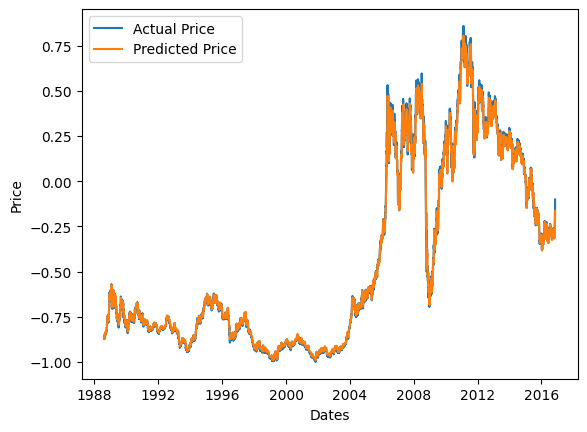

In [107]:
with torch.no_grad():
    predicted = model(X_train[:].to(device)).to('cpu').numpy()

plt.plot(train_dates,y_train, label='Actual Price')
plt.plot(train_dates,predicted, label='Predicted Price')

plt.xlabel('Dates')
plt.ylabel('Price')
plt.legend()
plt.show()


In [108]:
train_predictions = predicted.flatten()

dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])
train_predictions

array([0.88572454, 0.89036441, 0.89874285, ..., 2.28882241, 2.34472899,
       2.41725726])

In [109]:
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)
new_y_train = dc(dummies[:, 0])
new_y_train

array([0.88750003, 0.90099995, 0.88349995, ..., 2.38300001, 2.46149999,
       2.554     ])

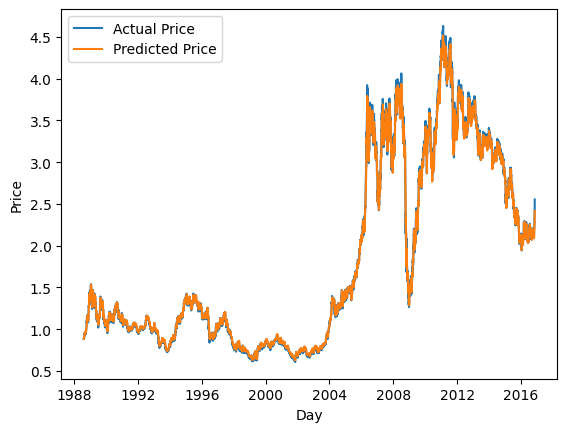

In [110]:
plt.plot(train_dates,new_y_train,  label='Actual Price')
plt.plot(train_dates,train_predictions, label='Predicted Price')
plt.xlabel('Day')
plt.ylabel('Price')
plt.legend()
plt.show()

In [111]:
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

array([2.50478659, 2.51941778, 2.52406984, ..., 3.78173542, 3.79689885,
       3.79245644])

In [112]:
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test
squared_differences = (new_y_test - test_predictions)**2

# Calculate the Root Mean Squared Error (RMSE)
rmse = np.sqrt(np.mean(squared_differences))
#rmse
absolute_differences = np.abs(new_y_test - test_predictions)

# Calculate the Mean Absolute Error (MAE)
mae = np.mean(absolute_differences)
rmse

0.06230424418636357

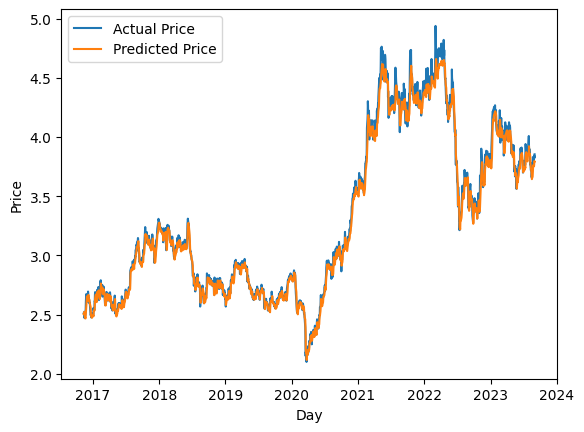

In [113]:
plt.plot(test_dates, new_y_test, label='Actual Price')
plt.plot(test_dates,test_predictions, label='Predicted Price')
plt.xlabel('Day')
plt.ylabel('Price')
plt.legend()
plt.show()


In [114]:
test_dates

7111   2016-11-11
7112   2016-11-14
7113   2016-11-15
7114   2016-11-16
7115   2016-11-17
          ...    
8883   2023-08-28
8884   2023-08-29
8885   2023-08-30
8886   2023-08-31
8887   2023-09-01
Name: Date, Length: 1777, dtype: datetime64[ns]